# Exercise 9b: Working with Satellite Data

## Aim: Use python tools to search for, download, and manipulate satellite data

### Issues covered:
- Search for and request data from a public STAC catalogue of satellite imagery
- Download satellite imagery as raster data 
- Read rasters into python using the rioxarray package
- Visualise single/multi-band raster data

### Introduction

A number of satellites take snapshots of the Earth’s surface from space. The images recorded by these remote sensors represent a very precious data source for any activity that involves monitoring changes on Earth. Satellite imagery is typically provided in the form of geospatial raster data, with the measurements in each grid cell (“pixel”) being associated to accurate geographic coordinate information.

In this notebook exercise we will explore how to access open satellite data using Python. In particular, we will consider [the Sentinel-2 data collection that is hosted on AWS](https://registry.opendata.aws/sentinel-2-l2a-cogs). This dataset consists of multi-band optical images acquired by the two satellites of [the Sentinel-2 mission](https://sentinel.esa.int/web/sentinel/missions/sentinel-2) and it is continuously updated with new images.


# 1. Search for satellite imagery

**The SpatioTemporal Asset Catalog (STAC) specification**

Current sensor resolutions and satellite revisit periods are such that terabytes of data products are added daily to the corresponding collections. Such datasets cannot be made accessible to users via full-catalog download. Space agencies and other data providers often offer access to their data catalogs through interactive Graphical User Interfaces (GUIs), see for instance the [Copernicus Open Access Hub portal](https://scihub.copernicus.eu/dhus/#/home) for the Sentinel missions. Accessing data via a GUI is a nice way to explore a catalog and get familiar with its content, but it represents a heavy and error-prone task that should be avoided if carried out systematically to retrieve data.

A service that offers programmatic access to the data enables users to reach the desired data in a more reliable, scalable and reproducible manner. An important element in the software interface exposed to the users, which is generally called the Application Programming Interface (API), is the use of standards. Standards, in fact, can significantly facilitate the reusability of tools and scripts across datasets and applications.

The SpatioTemporal Asset Catalog (STAC) specification is an emerging standard for describing geospatial data. By organizing metadata in a form that adheres to the STAC specifications, data providers make it possible for users to access data from different missions, instruments and collections using the same set of tools.


![Views of the STAC browser](https://carpentries-incubator.github.io/geospatial-python/fig/E05/STAC-browser.jpg)
Views of the radiant earth STAC browser

## More Resources on STAC
- [STAC specification](https://github.com/radiantearth/stac-spec#readme)
- [Tools based on STAC](https://stacindex.org/ecosystem)
- [STAC catalogs](https://stacindex.org/catalogs)

## Search a STAC catalog

The [STAC browser](https://radiantearth.github.io/stac-browser/#/) is a good starting point to discover available datasets, as it provides an up-to-date list of existing STAC catalogs. From the list, let's click on the "Earth Search" catalog, i.e. the access point to search the archive of Sentinel-2 images hosted on AWS.


## **Exercise:** Discover a STAC catalog
Let's take a moment to explore the Earth Search STAC catalog, which is the catalog indexing the Sentinel-2 collection
that is hosted on AWS. We can interactively browse this catalog using the STAC browser at [this link](https://radiantearth.github.io/stac-browser/#/external/earth-search.aws.element84.com/v1).

1. Open the link in your web browser. Which (sub-)catalogs are available?
2. Open the Sentinel-2 Level 2A collection, and select one item from the list. Each item corresponds to a satellite
"scene", i.e. a portion of the footage recorded by the satellite at a given time. Have a look at the metadata fields
and the list of assets. What kind of data do the assets represent?


<img src="../images/stac-catalog.png" width="800"/>

1. 9 subcatalogs are available, including a catalog for Landsat Collection 2, Level-2 and Sentinel-2 Level 2A (see left screenshot in the figure above).
2. When you select the Sentinel-2 Level 2A collection, and randomly choose one of the items from the list, you
should find yourself on a page similar to the image below. On the left side you will find
a list of the available assets: overview images (thumbnail and true color images), metadata files and the "real"
satellite images, one for each band captured by the Multispectral Instrument on board Sentinel-2.

<img src="../images/sentinel-collection.png" width="800"/>

When opening a catalog with the STAC browser, you can access the API URL by clicking on the "Source" button on the top
right of the page. By using this URL, we have access to the catalog content and, if supported by the catalog, to the
functionality of searching its items. For the Earth Search STAC catalog the API URL is:


In [1]:
api_url = "https://earth-search.aws.element84.com/v1"

You can query a STAC API endpoint from Python using the `pystac_client` library:

In [2]:
from pystac_client import Client

client = Client.open(api_url)


In the following, we ask for scenes belonging to the `sentinel-2-l2a` collection. This dataset includes Sentinel-2 data products pre-processed at level 2A (bottom-of-atmosphere reflectance) and saved in Cloud Optimized GeoTIFF (COG) format:

In [3]:
collection = "sentinel-2-l2a"  # Sentinel-2, Level 2A, Cloud Optimized GeoTiffs (COGs)

---

## A note on cloud-optimized GeoTIFFs

Cloud Optimized GeoTIFFs (COGs) are regular GeoTIFF files with some additional features that make them ideal to be employed in the context of cloud computing and other web-based services. This format builds on the widely-employed GeoTIFF format. In short, a GeoTIFF is a standard .tif image format with additional spatial (georeferencing) information embedded in the file as tags. These tags should include the following raster metadata:
- Extent
- Resolution
- Coordinate Reference System (CRS)
- Values that represent missing data (NoDataValue)

COGs, by extension, are regular GeoTIFF files with a special internal structure. One of the features of COGs is that data is organized in "blocks" that can be accessed remotely via independent HTTP requests. Data users can thus access the only blocks of a GeoTIFF that are relevant for their analysis, without having to download the full file. In addition, COGs typically include multiple lower-resolution versions of the original image, called "overviews", which can also be accessed independently. By providing this "pyramidal" structure, users that are not interested in the details provided by a high-resolution raster can directly access the lower-resolution versions of the same image, significantly saving on the downloading time. More information on the COG format can be found [here](https://www.cogeo.org).

---

We also ask for scenes intersecting a geometry defined using the `shapely` library (in this case, a point):

In [4]:
# shapely is a python library for manipulation and analysis of geometric objects.
from shapely.geometry import Point
# This line creates a Point object called point with the coordinates (4.89, 52.37). These coordinates typically represent a longitude and latitude pair, placing the point at a specific location on the Earth's surface.
point = Point(4.89, 52.37)  # AMS coordinates

Note: at this stage, we are only dealing with metadata, so no image is going to be downloaded yet. But even metadata can be quite bulky if a large number of scenes match our search! For this reason, we limit the search result to 10 items:


In [5]:
search = client.search(
    collections=[collection],
    intersects=point,
    max_items=10,
)

We submit the query and find out how many scenes match our search criteria (please note that this output can be different as more data is added to the catalog):



In [6]:
print(search.matched())

1391


Finally, we retrieve the metadata of the search results:

In [7]:
items = search.item_collection()

The variable `items` is an `ItemCollection` object. We can check its size by:

In [8]:
print(len(items))

10


which is consistent with the maximum number of items that we have set in the search criteria. We can iterate over the returned items and print these to show their IDs:

In [9]:
for item in items:
    print(item)

<Item id=S2B_31UFU_20241117_0_L2A>
<Item id=S2A_31UFU_20241115_0_L2A>
<Item id=S2A_31UFU_20241112_0_L2A>
<Item id=S2B_31UFU_20241110_0_L2A>
<Item id=S2B_31UFU_20241107_0_L2A>
<Item id=S2A_31UFU_20241105_0_L2A>
<Item id=S2A_31UFU_20241102_0_L2A>
<Item id=S2B_31UFU_20241031_0_L2A>
<Item id=S2B_31UFU_20241028_0_L2A>
<Item id=S2A_31UFU_20241026_0_L2A>


Each of the items contains information about the scene geometry, its acquisition time, and other metadata that can be accessed as a dictionary from the `properties` attribute.

Let's inspect the metadata associated with the first item of the search results:

In [10]:
item = items[0]
print("DATETIME:", item.datetime)
print("GEOMETRY:", item.geometry)
print("PROPERTIES:", item.properties)

DATETIME: 2024-11-17 10:46:23.489000+00:00
GEOMETRY: {'type': 'Polygon', 'coordinates': [[[5.24916239583845, 53.22839460224468], [4.823341904061397, 52.248473878463024], [6.071664488869862, 52.22257539160585], [6.141754296879459, 53.20819279121764], [5.24916239583845, 53.22839460224468]]]}
PROPERTIES: {'created': '2024-11-17T13:54:53.151Z', 'platform': 'sentinel-2b', 'constellation': 'sentinel-2', 'instruments': ['msi'], 'eo:cloud_cover': 44.449544, 'proj:epsg': 32631, 'mgrs:utm_zone': 31, 'mgrs:latitude_band': 'U', 'mgrs:grid_square': 'FU', 'grid:code': 'MGRS-31UFU', 'view:sun_azimuth': 170.718417722477, 'view:sun_elevation': 17.649923285331994, 's2:degraded_msi_data_percentage': 0.0067, 's2:nodata_pixel_percentage': 33.87168, 's2:saturated_defective_pixel_percentage': 0, 's2:cloud_shadow_percentage': 5.51994, 's2:vegetation_percentage': 15.127979, 's2:not_vegetated_percentage': 15.275878, 's2:water_percentage': 16.600806, 's2:unclassified_percentage': 3.021212, 's2:medium_proba_cloud

## **Exercise**: Search satellite scenes using metadata filters
Search for all the available Sentinel-2 scenes in the `Sentinel-2-Level-2A` collection that satisfy the following criteria:
- Intersect a provided bounding box, use ±0.01 deg in lat/lon from the previously defined point (hint: use `.buffer().bounds` methods on the shapely `point` object we created above). Give this as the `bbox` argument of `client.search()`.
- Have been recorded between 20 March 2020 and 30 March 2020 (hint: use `client.search()` with an argument `datetime="date1/date2"`);
- Have a cloud coverage smaller than 15% (hint: use the `query` argument of `client.search` - info can be found [here](https://pystac-client.readthedocs.io/en/latest/usage.html#query-extension)).
- Once you have added these as arguments to `client.search()` print out `.matched()` as we did early to see our number of matches.
- Retrieve the metadata of the item as we did earlier.

How many scenes are available? Save the search results in GeoJSON format as `search.json`.

## Access the assets

So far we have only discussed metadata - but how can one get to the actual images of a satellite scene (the "assets" in the STAC nomenclature)? These can be reached via links that are made available through the item's attribute `assets`.


In [ ]:
assets = items[0].assets  # first item's asset dictionary
print(assets.keys())

dict_keys(['aot', 'blue', 'coastal', 'granule_metadata', 'green', 'nir', 'nir08', 'nir09', 'red', 'rededge1', 'rededge2', 'rededge3', 'scl', 'swir16', 'swir22', 'thumbnail', 'tileinfo_metadata', 'visual', 'wvp', 'aot-jp2', 'blue-jp2', 'coastal-jp2', 'green-jp2', 'nir-jp2', 'nir08-jp2', 'nir09-jp2', 'red-jp2', 'rededge1-jp2', 'rededge2-jp2', 'rededge3-jp2', 'scl-jp2', 'swir16-jp2', 'swir22-jp2', 'visual-jp2', 'wvp-jp2'])


We can print a minimal description of the available assets:

In [18]:
for key, asset in assets.items():
    print(f"{key}: {asset.title}")

aot: Aerosol optical thickness (AOT)
blue: Blue (band 2) - 10m
coastal: Coastal aerosol (band 1) - 60m
granule_metadata: None
green: Green (band 3) - 10m
nir: NIR 1 (band 8) - 10m
nir08: NIR 2 (band 8A) - 20m
nir09: NIR 3 (band 9) - 60m
red: Red (band 4) - 10m
rededge1: Red edge 1 (band 5) - 20m
rededge2: Red edge 2 (band 6) - 20m
rededge3: Red edge 3 (band 7) - 20m
scl: Scene classification map (SCL)
swir16: SWIR 1 (band 11) - 20m
swir22: SWIR 2 (band 12) - 20m
thumbnail: Thumbnail image
tileinfo_metadata: None
visual: True color image
wvp: Water vapour (WVP)
aot-jp2: Aerosol optical thickness (AOT)
blue-jp2: Blue (band 2) - 10m
coastal-jp2: Coastal aerosol (band 1) - 60m
green-jp2: Green (band 3) - 10m
nir-jp2: NIR 1 (band 8) - 10m
nir08-jp2: NIR 2 (band 8A) - 20m
nir09-jp2: NIR 3 (band 9) - 60m
red-jp2: Red (band 4) - 10m
rededge1-jp2: Red edge 1 (band 5) - 20m
rededge2-jp2: Red edge 2 (band 6) - 20m
rededge3-jp2: Red edge 3 (band 7) - 20m
scl-jp2: Scene classification map (SCL)
swi

Among the others, assets include multiple raster data files (one per optical band, as acquired by the multi-spectral instrument), a thumbnail, a true-color image ("visual"), instrument metadata and scene-classification information ("SCL"). Let's get the URL links to the actual asset:


In [19]:
print(assets["thumbnail"].href)

https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/31/U/FU/2020/3/S2A_31UFU_20200328_1_L2A/thumbnail.jpg


This can be used to download the corresponding file:

![Overview of the true-colour image](../images/sentinel-image.png)

###### Overview of the true-colour image ("thumbnail")


Remote raster data can be directly opened via the `rioxarray` library. Raster data is a type of digital data representation used primary in GIS and remote sensing. It represents spatial information as a grid of cells/pixels.

We will learn more about this library in the next part of the notebook.

`rioxarray` is an extension of the `xarray` library that provides geospatial raster data capabilities. It bridges the gap between `xarray` and `rasterio` allowing users to work with multi-dimensional arrays that include geospatial metadata.

In [20]:
import rioxarray
# Get the URL for the Near Infrared (NIR) band.
nir_href = assets["nir"].href
# Open the raster file and load it into an xarray data array
nir = rioxarray.open_rasterio(nir_href)
print(nir)

<xarray.DataArray (band: 1, y: 10980, x: 10980)> Size: 241MB
[120560400 values with dtype=uint16]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 88kB 6e+05 6e+05 6e+05 ... 7.098e+05 7.098e+05
  * y            (y) float64 88kB 5.9e+06 5.9e+06 5.9e+06 ... 5.79e+06 5.79e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:       Area
    OVR_RESAMPLING_ALG:  AVERAGE
    _FillValue:          0
    scale_factor:        1.0
    add_offset:          0.0


We can then save the data to disk:

In [22]:
# save whole image to disk as a geotiff file
# NOTE: This might take a while
nir.rio.to_raster("data/nir.tif")

Since that might take a while, given there are over 10000 x 10000 = a hundred million pixels in the 10 meter NIR band, you can take a smaller subset before downloading it. Because the raster is a COG, we can download just what we need!

Here, we specify that we want to download the first (and only) band in the tif file, and a slice of the width and height dimensions.


In [23]:
# save portion of an image to disk
nir[0,1500:2200,1500:2200].rio.to_raster("data/nir_subset.tif")

The difference is 155 Megabytes for the large image vs about 1 Megabyte for the subset.


## **Exercise:** Downloading Landsat 8 Assets
In this exercise we put in practice all the skills we have learned thusfar to retrieve images from a different mission: [Landsat 8](https://www.usgs.gov/landsat-missions/landsat-8). In particular, we browse images from the [Harmonized Landsat Sentinel-2 (HLS) project](https://lpdaac.usgs.gov/products/hlsl30v002/), which provides images from NASA's Landsat 8 and ESA's Sentinel-2 that have been made consistent with each other. The HLS catalog is indexed in the NASA Common Metadata Repository (CMR) and it can be accessed from the STAC API endpoint at the following URL:
`https://cmr.earthdata.nasa.gov/stac/LPCLOUD`.

1. Using `pystac_client`, search for all assets of the Landsat 8 collection (`HLSL30.v2.0`) from February to March
  2021, intersecting the point with longitude/latitute coordinates (-73.97, 40.78) deg. (Hint: start by connecting to the STAC API endpoint, create a `Client` object, do a `client.search` with the `collections`, `intersects` and `datetime` arguments, retrieve the search results with `.item_collection()` and then print out the length of the resulting data.

2. You can sort and select by cloud cover using the following, where `items` is your item collection:
```
items_sorted = sorted(items, key=lambda x: x.properties["eo:cloud_cover"]) # sorting and then selecting by cloud cover
item = items_sorted[0]
print(item)
```
This line is using a lamdba function in the `key`. This is a shorthand way of defining a function without giving it a name, useful for a simple function that we only want to use once.

3. Visualize an item's thumbnail using `item.assets["browse"].href`.

![Thumbnail of the Landsat-8 scene](https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-public/HLSL30.020/HLS.L30.T18TWL.2021039T153324.v2.0/HLS.L30.T18TWL.2021039T153324.v2.0.jpg)

Thumbnail of the Landsat-8 scene

## Public catalogs, protected data

Publicly accessible catalogs and STAC endpoints do not necessarily imply publicly accessible data. Data providers, in
fact, may limit data access to specific infrastructures and/or require authentication. For instance, the NASA CMR STAC
endpoint considered in the last exercise offers publicly accessible metadata for the HLS collection, but most of the
linked assets are available only for registered users (the thumbnail is publicly accessible).

The authentication procedure for datasets with restricted access might differ depending on the data provider. For the
NASA CMR, follow these steps in order to access data using Python:

* Create a NASA Earthdata login account [here](https://urs.earthdata.nasa.gov);
* Set up a netrc file with your credentials, e.g. by using [this script](https://git.earthdata.nasa.gov/projects/LPDUR/repos/daac_data_download_python/browse/EarthdataLoginSetup.py);
* Define the following environment variables:



In [24]:
import os
os.environ["GDAL_HTTP_COOKIEFILE"] = "./cookies.txt"
os.environ["GDAL_HTTP_COOKIEJAR"] = "./cookies.txt"

## Key takeaways:

Accessing satellite images via the providers' API enables a more reliable and scalable data retrieval.

 - STAC catalogs can be browsed and searched using the same tools and scripts.
 - `rioxarray` allows you to open and download remote raster files.
 
---

# 2. Read and visualise raster data

Next, we introduce the fundamental principles, packages and metadata/raster attributes for working with raster data (pixelated/gridded data) in Python. We will also explore how Python handles missing and bad data values.

[`rioxarray`](https://corteva.github.io/rioxarray/stable/) is the Python package we will use throughout the rest of this notebook to work with raster data. It is based on the popular [`rasterio`](https://rasterio.readthedocs.io/en/latest/) package for working with rasters and [`xarray`](https://xarray.pydata.org/en/stable/) for working with multi-dimensional arrays.
`rioxarray` extends `xarray` by providing top-level functions (e.g. the `open_rasterio` function to open raster datasets) and by adding a set of methods to the main objects of the `xarray` package (the `Dataset` and the `DataArray`). These additional methods are made available via the `rio` accessor and become available from `xarray` objects after importing `rioxarray`.

We will also use the [`pystac`](https://github.com/stac-utils/pystac) package (library for working with STAC in Python) to load rasters from the search results we created in the previous section.

### About Raster Data

Raster data is any pixelated (or gridded) data where each pixel is associated
with a specific geographic location. The value of a pixel can be
continuous (e.g. elevation) or categorical (e.g. land use). If this sounds
familiar, it is because this data structure is very common: it's how
we represent any digital image. A geospatial raster is only different
from a digital photo in that it is accompanied by spatial information
that connects the data to a particular location. This includes the
raster's extent and cell size, the number of rows and columns, and
its coordinate reference system (or CRS).

![raster-concept](https://carpentries-incubator.github.io/geospatial-python/fig/E01/raster_concept.png)
###### Raster Concept (Source: National Ecological Observatory Network (NEON))

Some examples of continuous rasters include:

1. Precipitation maps.
2. Maps of tree height derived from LiDAR data.
3. Elevation values for a region.

A map of elevation for Harvard Forest derived from the [NEON AOP LiDAR sensor](https://www.neonscience.org/data-collection/airborne-remote-sensing)
is below. Elevation is represented as a continuous numeric variable in this map. The legend
shows the continuous range of values in the data from around 300 to 420 meters.

![elevation plot](https://carpentries-incubator.github.io/geospatial-python/fig/E01/continuous-elevation-HARV-plot-01.png)
###### Continuous Elevation Map: HARV Field Site


## Load a Raster and View Attributes
In the previous episode, we searched for Sentinel-2 images, and then saved the search results to a file: `data/search.json`. This contains the information on where and how to access the target images from a remote repository. We can use the function `pystac.ItemCollection.from_file()` to load the search results as an `Item` list.


In [26]:
import pystac
items = pystac.ItemCollection.from_file("data/search.json")
items

In the search results, we have 7 `Item` type objects, corresponding to several Sentinel-2 scenes from March 21th and 28th in 2020. We will focus on the scene `S2A_31UFU_20200328_0_L2A`, and load band `nir09` (central wavelength 945 nm). We can load this band using the function `rioxarray.open_rasterio()`, via the Hypertext Reference `href` (commonly referred to as a URL):

## **Exercise:** finding the right item and asset
How do we go about selecting the correct item and asset from our ItemCollection we just loaded?
1. Find the item corresponding to scene S2A_31UFU_20200328_0_L2A. Use the following loop:
```
for item in items:
    if item.id == "S2A_31UFU_20200328_0_L2A":
        break
item
```
This loops through each item in the `items` collection we just retrieved. It stops (because of the `break` when the `item.id` matches the one we want which means `item` is then equal to the corresponding item.

2. Find the asset `href` for the `nir09` band in the item's asset dictionary. (Hint: use the `item.assets[].href` syntax).

3. Load it using rioxarray's `open_rasterio` method into a variable called `raster_ams_b9`.

By calling the variable name in the Jupyter notebook we can get a quick look at the shape and attributes of the data.

In [32]:
raster_ams_b9

<xarray.DataArray (band: 1, y: 1830, x: 1830)>
[3348900 values with dtype=uint16]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 6e+05 6.001e+05 6.002e+05 ... 7.097e+05 7.098e+05
  * y            (y) float64 5.9e+06 5.9e+06 5.9e+06 ... 5.79e+06 5.79e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:       Area
    OVR_RESAMPLING_ALG:  AVERAGE
    _FillValue:          0
    scale_factor:        1.0
    add_offset:          0.0

The first call to `rioxarray.open_rasterio()` opens the file from remote or local storage, and then returns a `xarray.DataArray` object. The object is stored in a variable, i.e. `raster_ams_b9`. Reading in the data with `xarray` instead of `rioxarray` also returns a `xarray.DataArray`, but the output will not contain the geospatial metadata (such as projection information). You can use numpy functions or built-in Python math operators on a `xarray.DataArray` just like a numpy array. Calling the variable name of the `DataArray` also prints out all of its metadata information.

The output tells us that we are looking at an `xarray.DataArray`, with `1` band, `1830` rows, and `1830` columns. We can also see the number of pixel values in the `DataArray`, and the type of those pixel values, which is unsigned integer (or `uint16`). The `DataArray` also stores different values for the coordinates of the `DataArray`. When using `rioxarray`, the term coordinates refers to spatial coordinates like `x` and `y` but also the `band` coordinate. Each of these sequences of values has its own data type, like `float64` for the spatial coordinates and `int64` for the `band` coordinate.

This `DataArray` object also has a couple of attributes that are accessed like `.rio.crs`, `.rio.nodata`, and `.rio.bounds()`, which contain the metadata for the file we opened. Note that many of the metadata are accessed as attributes without `()`, but `bounds()` is a method (i.e. a function in an object) and needs parentheses.


In [30]:
print(raster_ams_b9.rio.crs)
print(raster_ams_b9.rio.nodata)
print(raster_ams_b9.rio.bounds())
print(raster_ams_b9.rio.width)
print(raster_ams_b9.rio.height)

EPSG:32631
0
(600000.0, 5790240.0, 709800.0, 5900040.0)
1830
1830


The Coordinate Reference System, or `raster_ams_b9.rio.crs`, is reported as the string `EPSG:32631`. The `nodata` value is encoded as 0 and the bounding box corners of our raster are represented by the output of `.bounds()` as a `tuple` (like a list but you can't edit it). The height and width match what we saw when we printed the `DataArray`, but by using `.rio.width` and `.rio.height` we can access these values if we need them in calculations.

We will be exploring this data throughout this episode. By the end of this episode, you will be able to understand and explain the metadata output.


<span style="color: blue;">*TIP: To improve code readability, file and object names should be used that make it clear what is in the file. The data for this episode covers Amsterdam, and is from Band 9, so we'll use a naming convention of `raster_ams_b9` for the variable name.*</span>


## Visualize a Raster

After viewing the attributes of our raster, we can examine the raw values of the array with `.values`:




In [31]:
raster_ams_b9.values

array([[[    0,     0,     0, ...,  8888,  9075,  8139],
        [    0,     0,     0, ..., 10444, 10358,  8669],
        [    0,     0,     0, ..., 10346, 10659,  9168],
        ...,
        [    0,     0,     0, ...,  4295,  4289,  4320],
        [    0,     0,     0, ...,  4291,  4269,  4179],
        [    0,     0,     0, ...,  3944,  3503,  3862]]], dtype=uint16)

This can give us a quick view of the values of our array, but only at the corners. Since our raster is loaded in Python as a `DataArray` type, we can plot this in one line similar to a pandas `DataFrame` with `DataArray.plot()`.

__Exercise: plot our raster file using the plot() method__

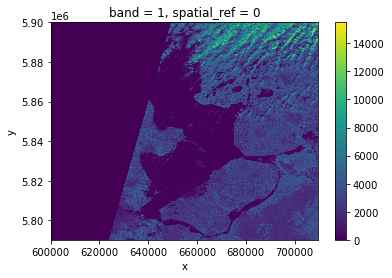

In [35]:
raster_ams_b9.plot()

Notice that `rioxarray` helpfully allows us to plot this raster with spatial coordinates on the x and y axis (this is not the default in many cases with other functions or libraries).

This plot shows the satellite measurement of the spectral band `nir09` for an area that covers part of the Netherlands. According to the [Sentinel-2 documentaion](https://sentinels.copernicus.eu/web/sentinel/technical-guides/sentinel-2-msi/msi-instrument), this is a band with the central wavelength of 945nm, which is sensitive to water vapor. It has a spatial resolution of 60m. Note that the `band=1` in the image title refers to the ordering of all the bands in the  `DataArray`, not the Sentinel-2 band number `09` that we saw in the pystac search results.

With a quick view of the image, we notice that half of the image is blank, no data is captured. We also see that the cloudy pixels at the top have high reflectance values, while the contrast of everything else is quite low. This is expected because this band is sensitive to the water vapor. However if one would like to have a better color contrast, one can add the option `robust=True`, which displays values between the 2nd and 98th percentile:

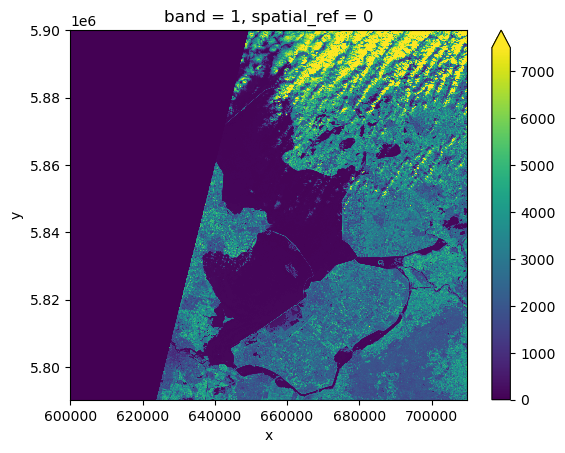

In [32]:
raster_ams_b9.plot(robust=True)

Now the color limit is set in a way fitting most of the values in the image. We have a better view of the ground pixels.

---

*NOTE: The option `robust=True` always forces displaying values between the 2nd and 98th percentile. Of course, this will not work for every case. For a customized displaying range, you can also manually specifying the keywords `vmin` and `vmax`. For example plotting between `100` and `7000`.*

__Exercise: plot the raster with vmin and vmax arguments__

---

## View Raster Coordinate Reference System (CRS) in Python
Another information that we're interested in is the CRS, and it can be accessed with `.rio.crs`. To find out more about CRS look at [the earlier
episode](https://carpentries-incubator.github.io/geospatial-python/instructor/03-crs.html) in the software carpentry course.
Now we will see how features of the CRS appear in our data file and what
meanings they have. We can view the CRS string associated with our DataArray's `rio` object using the `crs`
attribute.


In [34]:
print(raster_ams_b9.rio.crs)

EPSG:32631


To print the EPSG code number (unique identifier used to represent coordinate systems) as an `int`, we use the `.to_epsg()` method:

In [35]:
raster_ams_b9.rio.crs.to_epsg()

32631

EPSG codes are great for succinctly representing a particular coordinate reference system. But what if we want to see more details about the CRS, like the units? For that, we can use `pyproj`, a library for representing and working with coordinate reference systems.

In [36]:
from pyproj import CRS
epsg = raster_ams_b9.rio.crs.to_epsg()
crs = CRS(epsg)
crs

<Projected CRS: EPSG:32631>
Name: WGS 84 / UTM zone 31N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 0°E and 6°E, northern hemisphere between equator and 84°N, onshore and offshore. Algeria. Andorra. Belgium. Benin. Burkina Faso. Denmark - North Sea. France. Germany - North Sea. Ghana. Luxembourg. Mali. Netherlands. Niger. Nigeria. Norway. Spain. Togo. United Kingdom (UK) - North Sea.
- bounds: (0.0, 0.0, 6.0, 84.0)
Coordinate Operation:
- name: UTM zone 31N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

The `CRS` class from the `pyproj` library allows us to create a `CRS` object with methods and attributes for accessing specific information about a CRS, or the detailed summary shown above.

A particularly useful attribute is `area_of_use`, which shows the geographic bounds that the CRS is intended to be used.



In [37]:
crs.area_of_use

AreaOfUse(west=0.0, south=0.0, east=6.0, north=84.0, name='Between 0°E and 6°E, northern hemisphere between equator and 84°N, onshore and offshore. Algeria. Andorra. Belgium. Benin. Burkina Faso. Denmark - North Sea. France. Germany - North Sea. Ghana. Luxembourg. Mali. Netherlands. Niger. Nigeria. Norway. Spain. Togo. United Kingdom (UK) - North Sea.')

## **Exercise**: find the axes units of the CRS
What units are our data in? See if you can find a method to examine this information using `help(crs)` or `dir(crs)`

Let's break down the pieces of the `pyproj` CRS summary. The string contains all of the individual CRS elements that Python or another GIS might need, separated into distinct sections, and datum.

In [44]:
crs

<Projected CRS: EPSG:32631>
Name: WGS 84 / UTM zone 31N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 0°E and 6°E, northern hemisphere between equator and 84°N, onshore and offshore. Algeria. Andorra. Belgium. Benin. Burkina Faso. Denmark - North Sea. France. Germany - North Sea. Ghana. Luxembourg. Mali. Netherlands. Niger. Nigeria. Norway. Spain. Togo. United Kingdom (UK) - North Sea.
- bounds: (0.0, 0.0, 6.0, 84.0)
Coordinate Operation:
- name: UTM zone 31N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

* **Name** of the projection is UTM zone 31N (UTM has 60 zones, each 6-degrees of longitude in width). The underlying datum is WGS84. Universal Transverse Mercator (UTM) is a map projection system for assigning coordinates to locations.
* **Axis Info**: the CRS shows a Cartesian system with two axes, easting and northing, in meter units.
* **Area of Use**: the projection is used for a particular range of longitudes `0°E to 6°E` in the northern hemisphere (`0.0°N to 84.0°N`)
* **Coordinate Operation**: the operation to project the coordinates (if it is projected) onto a cartesian (x, y) plane. Transverse Mercator is accurate for areas with longitudinal widths of a few degrees, hence the distinct UTM zones.
* **Datum**: Details about the datum, or the reference point for coordinates. `WGS 84` and `NAD 1983` are common datums. `NAD 1983` is [set to be replaced in 2022](https://en.wikipedia.org/wiki/Datum_of_2022).

Note that the zone is unique to the UTM projection. Not all CRSs will have a
zone. Below is a simplified view of US UTM zones.

![UTMZones](https://upload.wikimedia.org/wikipedia/commons/thumb/8/8d/Utm-zones-USA.svg/1920px-Utm-zones-USA.svg.png)
###### The UTM zones across the continental United States (Chrismurf at English Wikipedia, via [Wikimedia Commons](https://en.wikipedia.org/wiki/Universal_Transverse_Mercator_coordinate_system#/media/File:Utm-zones-USA.svg) (CC-BY))

## Calculate Raster Statistics

It is useful to know the minimum or maximum values of a raster dataset.

__Exercise: compute these and other descriptive statistics with `min`, `max`, `mean`, and `std`.__


The information above includes a report of the min, max, mean, and standard deviation values, along with the data type. If we want to see specific quantiles, we can use xarray's `.quantile()` method. For example for the 25% and 75% quantiles:

In [46]:
print(raster_ams_b9.quantile([0.25, 0.75]))

<xarray.DataArray (quantile: 2)> Size: 16B
array([   0., 2911.])
Coordinates:
  * quantile  (quantile) float64 16B 0.25 0.75


---
*NOTE: You could also get each of these values one by one using `numpy`.*


In [47]:
import numpy
print(numpy.percentile(raster_ams_b9, 25))
print(numpy.percentile(raster_ams_b9, 75))

0.0
2911.0


You may notice that `raster_ams_b9.quantile` and `numpy.percentile` didn't require an argument specifying the axis or dimension along which to compute the quantile. This is because `axis=None` is the default for most numpy functions, and therefore `dim=None` is the default for most xarray methods. It's always good to check out the docs on a function to see what the default arguments are, particularly when working with multi-dimensional image data. To do so, we can use `help(raster_ams_b9.quantile)` (or `?raster_ams_b9.percentile` in a Jupyter notebook), e.g.


In [48]:
?raster_ams_b9.quantile

Signature:
raster_ams_b9.quantile(
    q: 'ArrayLike',
    dim: 'Dims' = None,
    *,
    method: 'QuantileMethods' = 'linear',
    keep_attrs: 'bool | None' = None,
    skipna: 'bool | None' = None,
    interpolation: 'QuantileMethods | None' = None,
) -> 'Self'
Docstring:
Compute the qth quantile of the data along the specified dimension.

Returns the qth quantiles(s) of the array elements.

Parameters
----------
q : float or array-like of float
    Quantile to compute, which must be between 0 and 1 inclusive.
dim : str or Iterable of Hashable, optional
    Dimension(s) over which to apply quantile.
method : str, default: "linear"
    This optional parameter specifies the interpolation method to use when the
    desired quantile lies between two data points. The options sorted by their R
    type as summarized in the H&F paper [1]_ are:

        1. "inverted_cdf"
        2. "averaged_inverted_cdf"
        3. "closest_observation"
        4. "interpolated_inverted_cdf"
        5. "haz

---

## Dealing with Missing Data
So far, we have visualized a band of a Sentinel-2 scene and calculated its statistics. However, we need to take missing data into account. Raster data often has a "no data value" associated with it and for raster datasets read in by `rioxarray`. This value is referred to as `nodata`. This is a value assigned to pixels where data is missing or no data were collected. There can be different cases that cause missing data, and it's common for other values in a raster to represent different cases. The most common example is missing data at the edges of rasters.

By default the shape of a raster is always rectangular. So if we have a dataset that has a shape that isn't rectangular, some pixels at the edge of the raster will have no data values. This often happens when the data were collected by a sensor which only flew over some part of a defined region.

As we have seen above, the `nodata` value of this dataset (`raster_ams_b9.rio.nodata`) is 0. When we have plotted the band data, or calculated statistics, the missing value was not distinguished from other values. Missing data may cause some unexpected results. For example, the 25th percentile we just calculated was 0, probably reflecting the presence of a lot of missing data in the raster.

To distinguish missing data from real data, one possible way is to use `NaN` (Not a Number) to represent them. This can be done by specifying `masked=True` when loading the raster:


In [49]:
raster_ams_b9 = rioxarray.open_rasterio(items[0].assets["nir09"].href, masked=True)

One can also use the `where` function to select all the pixels which are different from the `nodata` value of the raster:

In [50]:
raster_ams_b9.where(raster_ams_b9!=raster_ams_b9.rio.nodata)

<xarray.DataArray (band: 1, y: 1830, x: 1830)> Size: 13MB
array([[[   nan,    nan,    nan, ..., 10061., 10200., 10172.],
        [   nan,    nan,    nan, ..., 10424., 10315.,  9763.],
        [   nan,    nan,    nan, ..., 10328., 10648., 10405.],
        ...,
        [   nan,    nan,    nan, ...,  4298.,  4343.,  4315.],
        [   nan,    nan,    nan, ...,  4284.,  4284.,  4155.],
        [   nan,    nan,    nan, ...,  3935.,  3545.,  3958.]]],
      dtype=float32)
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 15kB 6e+05 6.001e+05 ... 7.097e+05 7.098e+05
  * y            (y) float64 15kB 5.9e+06 5.9e+06 5.9e+06 ... 5.79e+06 5.79e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:       Area
    OVR_RESAMPLING_ALG:  AVERAGE
    scale_factor:        1.0
    add_offset:          0.0

Either way will change the `nodata` value from `0` to `nan`. Now if we compute the statistics again the missing data will not be considered.

__Exercise: Compute the statistics (`min`, `max`, `mean`, `std`) again:__

And if we plot the image, the `nodata` pixels are not shown because they are not `0` anymore. 

__Exercise: plot the masked image with `robust` set to true__

One should notice that there is a side effect of using `nan` instead of `0` to represent the missing data: the data type of the `DataArray` was changed from integers to float. This need to be taken into consideration when the data type matters in your application.

## Raster Bands
So far we looked into a single band raster, i.e. the `nir09` band of a Sentinel-2 scene. However, to get a smaller, non georeferenced version of the scene, one may also want to visualize the true-color overview of the region. This is provided as a multi-band raster -- a raster dataset that contains more than one band.

![Sketch of a multi-band raster image](https://carpentries-incubator.github.io/geospatial-python/fig/E06/single_multi_raster.png)
###### Sketch of a multi-band raster image

The `overview` asset in the Sentinel-2 scene is a multiband asset. Similar to `nir09`, we can load it by:

In [ ]:
raster_ams_overview = rioxarray.open_rasterio(items[0].assets['visual'].href, overview_level=3)
raster_ams_overview

<xarray.DataArray (band: 3, y: 687, x: 687)> Size: 1MB
[1415907 values with dtype=uint8]
Coordinates:
  * band         (band) int64 24B 1 2 3
  * x            (x) float64 5kB 6.001e+05 6.002e+05 ... 7.096e+05 7.097e+05
  * y            (y) float64 5kB 5.9e+06 5.9e+06 5.9e+06 ... 5.79e+06 5.79e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:       Area
    OVR_RESAMPLING_ALG:  AVERAGE
    _FillValue:          0
    scale_factor:        1.0
    add_offset:          0.0

The band number comes first when GeoTiffs are read with the `.open_rasterio()` function. As we can see in the `xarray.DataArray` object, the shape is now `(band: 3, y: 687, x: 687)`, with three bands in the `band` dimension. It's always a good idea to examine the shape of the raster array you are working with and make sure it's what you expect. Many functions, especially the ones that plot images, expect a raster array to have a particular shape. One can also check the shape using the `.shape` attribute:

In [54]:
raster_ams_overview.shape

(3, 687, 687)

One can visualize the multi-band data with the `DataArray.plot.imshow()` function:

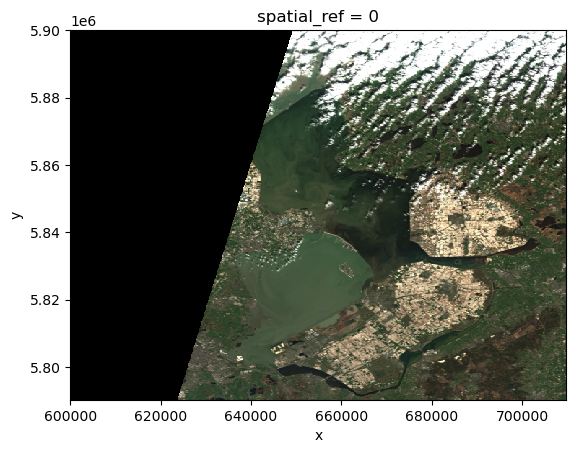

In [55]:
raster_ams_overview.plot.imshow()

Note that the `DataArray.plot.imshow()` function makes assumptions about the shape of the input DataArray, that since it has three channels, the correct colormap for these channels is RGB. It does not work directly on image arrays with more than 3 channels. One can replace one of the RGB channels with another band, to make a false-color image.

## **Exercise**: set the plotting aspect ratio
As seen in the figure above, the true-color image is stretched. Visualize it with the right aspect ratio. You can use the [documentation](https://xarray.pydata.org/en/stable/generated/xarray.DataArray.plot.imshow.html) of `DataArray.plot.imshow()`.

We can calculate the aspect ratio with the `rio.height` and `rio.width` properties on our rioxarray dataset. Remember we need to use the `.rio` accessor to access rasterio's properties (see [the xarray docs](https://docs.xarray.dev/en/stable/internals/extending-xarray.html) for more info if you're interested).

We can then set the kwarg `aspect=` to our calculated value for aspect ratio. Note that according to the [documentation](https://xarray.pydata.org/en/stable/generated/xarray.DataArray.plot.imshow.html) of `DataArray.plot.imshow()`, when specifying the `aspect` argument, `size` also needs to be provided, so we just choose the size to be 5 inches.

## Key takeaways:
- `rioxarray` and `xarray` are for working with multidimensional arrays like pandas is for working with tabular data.
- `rioxarray` stores CRS information as a CRS object that can be converted to an EPSG code or PROJ4 string.
- Missing raster data are filled with `nodata` values, which should be handled with care for statistics and visualization.